# Project 2: Customer Segmentation using RFM Analysis

In [1]:
# importing the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
import datetime as dt
import feature_engine
from feature_engine.outliers import Winsorizer
import warnings
warnings.filterwarnings("ignore")

## Task 1: Data Preprocessing

### Importing the Dataset

In [2]:
df = pd.read_csv('data.csv',encoding="ISO-8859-1")

### Exploring the dataset

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Question 1 - Data Overview

#### a) What is the size of the dataset in terms of the number of rows and columns?

In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of fields in the dataset:", df.shape[1])

Number of rows in the dataset: 541909
Number of fields in the dataset: 8


#### b) Can you provide a brief description of each column in the dataset?

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# Summary statistics for categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


#### Inferences:

Quantity:
1. The average quantity of products in a transaction is approximately 9.55.
1. The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders.
1. The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

UnitPrice:
1. The average unit price of the products is approximately 4.61.
1. The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.
1. Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

CustomerID:
1. There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.

InvoiceNo:
1. There are 25900 unique invoice numbers, indicating 25900 separate transactions.
1. The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.

StockCode:
1. There are 4070 unique stock codes representing different products.
1. The most frequent stock code is 85123A, appearing 2313 times in the dataset.

Description:
1. There are 4223 unique product descriptions.
1. The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.
1. There are some missing values in this column which need to be treated.

Country:
1. The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.

#### c) What is the time period covered by this dataset?

In [9]:
print("Time period of the data varies from", df['InvoiceDate'].min(), "to",df['InvoiceDate'].max())

Time period of the data varies from 1/10/2011 10:04 to 9/9/2011 9:52


### Data Cleaning

In [10]:
missing_data = df.isnull().sum()
print(missing_data,'\n')

for col in df.columns:
    pct_missing = df[col].isnull().mean()
    print(f'{col} - {pct_missing :.1%}')

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64 

InvoiceNo - 0.0%
StockCode - 0.0%
Description - 0.3%
Quantity - 0.0%
InvoiceDate - 0.0%
UnitPrice - 0.0%
CustomerID - 24.9%
Country - 0.0%


1. As there is a significant percentage of CustomerID values missing, we can replace them with 0.
2. Also replacing the missing Description values with 'Unknown'. 

In [11]:
df['Description'] = df['Description'].fillna('Unknown')
df['CustomerID']  = df['CustomerID'].fillna(0)

In [12]:
missing_data = df.isnull().sum()
print(missing_data,'\n')

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 



In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### Converting "InvoiceDate" column to a datetime data type:

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Check for duplicates

In [15]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 5268 duplicate rows that need to be removed.


#### Dropping duplicates

In [16]:
# Removing duplicate rows
df.drop_duplicates(inplace=True,keep='first')

#### Checking one to one mapping

In [17]:
# Check if each StockCode has only one unique Description
unique_counts = df.groupby('StockCode')['Description'].nunique()

# If any StockCode has more than one unique Description, it indicates an issue
if (unique_counts > 1).any():
    print("There is an issue with the one-to-one mapping between StockCode and Description.")
    # Display StockCodes with more than one unique Description for further investigation
    print(unique_counts[unique_counts > 1])
else:
    print("The mapping between StockCode and Description is one-to-one.")

There is an issue with the one-to-one mapping between StockCode and Description.
StockCode
10002           2
10080           3
10123C          2
10133           2
15030           2
               ..
DOT             2
POST            2
gift_0001_10    2
gift_0001_20    2
gift_0001_30    2
Name: Description, Length: 1324, dtype: int64


#### Checking for Negative Values

In [18]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [19]:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0.0,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0.0,United Kingdom


### Adding neccessary columns into the dataframe

In [20]:
#Cost Price
import random

cost_range_start = 0.1  # Minimum value for cost price
cost_range_end = 0.8 # Maximum value for cost price 

df.loc[:, 'CostPrice'] = df['UnitPrice'] * random.uniform(cost_range_start, cost_range_end)

In [21]:
# Customer Feedback
import pandas as pd
import numpy as np
feedback_values = ["Not worth the price.", "Highly recommended!",
                   "Poor quality.", "Fast shipping.",
                   "Excellent customer service.", "Great product!"]

# Generate random feedback column
np.random.seed(42)  # Set random seed for reproducibility
feedback_column = np.random.choice(feedback_values, size=df.shape[0])
df.loc[:, 'Customer Feedback'] = feedback_column
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CostPrice,Customer Feedback
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.812711,Fast shipping.
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1.954884,Poor quality.
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0.604237,Not worth the price.
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,1.492820,Not worth the price.
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2.950098,Fast shipping.
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2.950098,Highly recommended!


In [22]:
#PaymentMode

payment_modes = [
    "Cash",
    "Credit card",
    "Debit card",
    "PayPal",
    "Mobile payment",
    "Wire transfer",
]

# Define probabilities for each payment method
payment_probabilities = [0.2, 0.3, 0.1, 0.15, 0.1, 0.15]

# Generate random feedback column with specified probabilities
np.random.seed(42)  # Set random seed for reproducibility
payment_column = np.random.choice(payment_modes, size=df.shape[0], p=payment_probabilities)

df = df.copy()

df['PaymentMode'] = payment_column
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CostPrice,Customer Feedback,PaymentMode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.812711,Fast shipping.,Credit card
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Wire transfer
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1.954884,Poor quality.,PayPal
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Debit card
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Cash


In [23]:
#adding up this new column for further analysis
random_days = np.random.randint(1, 11, size=len(df))

# Add the random number of days to the existing dates
df['Order_FulfillmentDate'] = pd.to_datetime(df['InvoiceDate']) + pd.to_timedelta(random_days, unit='D')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CostPrice,Customer Feedback,PaymentMode,Order_FulfillmentDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.812711,Fast shipping.,Credit card,2010-12-08 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Wire transfer,2010-12-02 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1.954884,Poor quality.,PayPal,2010-12-02 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Debit card,2010-12-07 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Cash,2010-12-02 08:26:00


### Question 2 - Customer Analysis

#### How many unique customers are there in the dataset?

In [24]:
print("There are",df.CustomerID.nunique(),"unique customers")

There are 4373 unique customers


#### What is the distribution of the number of orders per customer?

In [25]:
customer_order_dist = df.groupby('CustomerID',as_index=False).agg({'InvoiceNo':'count'})
customer_order_dist.columns = ('CustomerID','order_count')
customer_order_dist.CustomerID = customer_order_dist.CustomerID.astype(int)
customer_order_dist = customer_order_dist[customer_order_dist['CustomerID']>0]
customer_order_dist.sort_values(by='order_count',inplace=True,ascending = False)

Text(0.5, 1.0, 'Distribution of number of orders per customer')

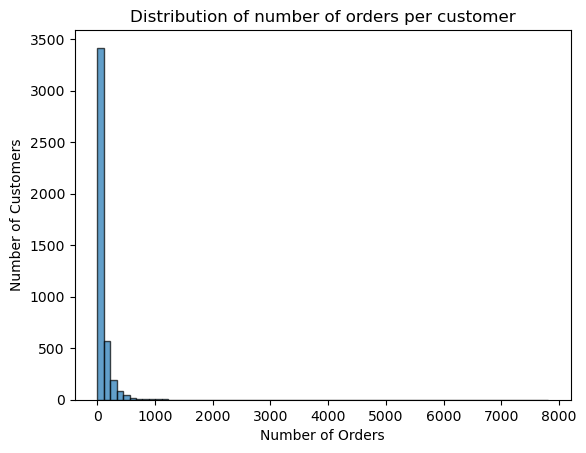

In [26]:
plt.hist(customer_order_dist.order_count, bins=70, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.title('Distribution of number of orders per customer')

#### Can you identify the top 5 customers who have made the most purchases by order count?

In [27]:
print("Top 5 customers who have made the most purchases by order count")
top_customers = customer_order_dist.sort_values(by='order_count', ascending=False).head(5)
top_customers

Top 5 customers who have made the most purchases by order count


,CustomerID,order_count
4043,17841,7812
1896,14911,5898
1301,14096,5128
331,12748,4459
1675,14606,2759


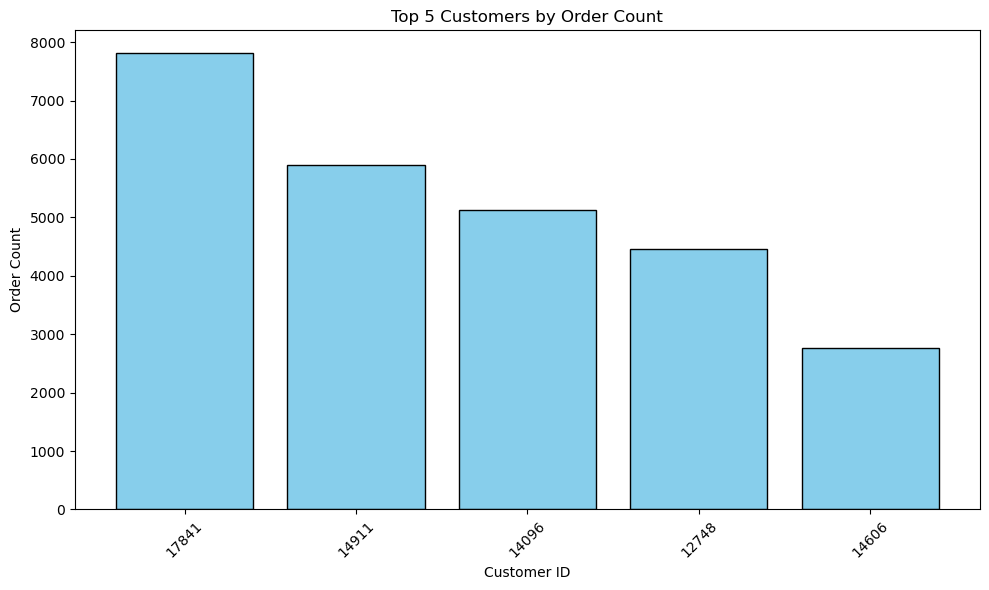

In [28]:
# Plot bar chart with adjustments
plt.figure(figsize=(10, 6))
plt.bar(top_customers['CustomerID'].astype(str), top_customers['order_count'], color='skyblue', edgecolor='black')
plt.title('Top 5 Customers by Order Count')
plt.xlabel('Customer ID')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout for better visibility
plt.show()

### Question 3 - Product Analysis

#### a) What are the top 10 most frequently purchased products?

In [29]:
freq_purchased_products = df['StockCode'].value_counts().reset_index()
freq_purchased_products.columns = ['StockCode', 'Frequency_of_products']
print('The top 10 most frequently purchased products are:')
freq_purchased_products.head(10)

The top 10 most frequently purchased products are:


,StockCode,Frequency_of_products
0,85123A,2301
1,22423,2192
2,85099B,2156
3,47566,1720
4,20725,1626
5,84879,1489
6,22720,1469
7,22197,1468
8,21212,1367
9,22383,1328


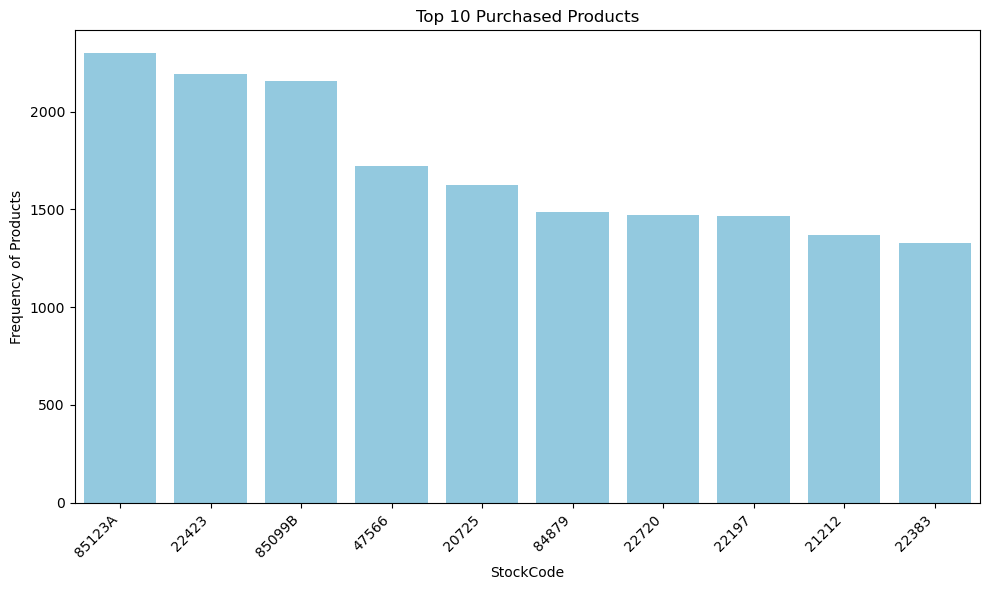

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='StockCode', y='Frequency_of_products', color='skyblue', data=freq_purchased_products.head(10))
plt.xlabel('StockCode')
plt.ylabel('Frequency of Products')
plt.title('Top 10 Purchased Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#### b) What is the average price of products in the dataset?

In [31]:
prod_avg_price = df['UnitPrice'].mean()
print('The average price of products in the dataset is',prod_avg_price)

The average price of products in the dataset is 4.632655674836623


#### c) Can you find out which product category generates the highest revenue?

In [32]:
df['Total_Price'] = df['Quantity'] * df['UnitPrice']
revenue_of_category = df.groupby('StockCode')['Total_Price'].sum().reset_index()
revenue_of_category.columns = ['StockCode', 'Revenue_of_products']

revenue_of_category.sort_values(by='Revenue_of_products', inplace=True, ascending=False)

highest_revenue_category = revenue_of_category.iloc[0]['StockCode']
print('Product category that generates the highest revenue is:', highest_revenue_category)

Product category that generates the highest revenue is: DOT


In [33]:
revenue_of_category

,StockCode,Revenue_of_products
4059,DOT,206245.480
1348,22423,164459.490
2733,47566,98243.880
3536,85123A,97838.450
3515,85099B,92175.790
...,...,...
4039,BANK CHARGES,-7175.639
4041,CRUK,-7933.430
4038,B,-11062.060
4060,M,-69034.190


### Question 4 - Time Analysis

#### a) Is there a specific day of the week or time of day when most orders are placed?

In [34]:
df['Week'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

orders_day = df['Week'].mode().values[0]
orders_hour = df['Hour'].mode().values[0]

print("Most orders are placed - by week analysis:", orders_day)
print("Most orders are placed - by time(hour) analysis in 24 hours clock:", orders_hour)

Most orders are placed - by week analysis: Thursday
Most orders are placed - by time(hour) analysis in 24 hours clock: 12


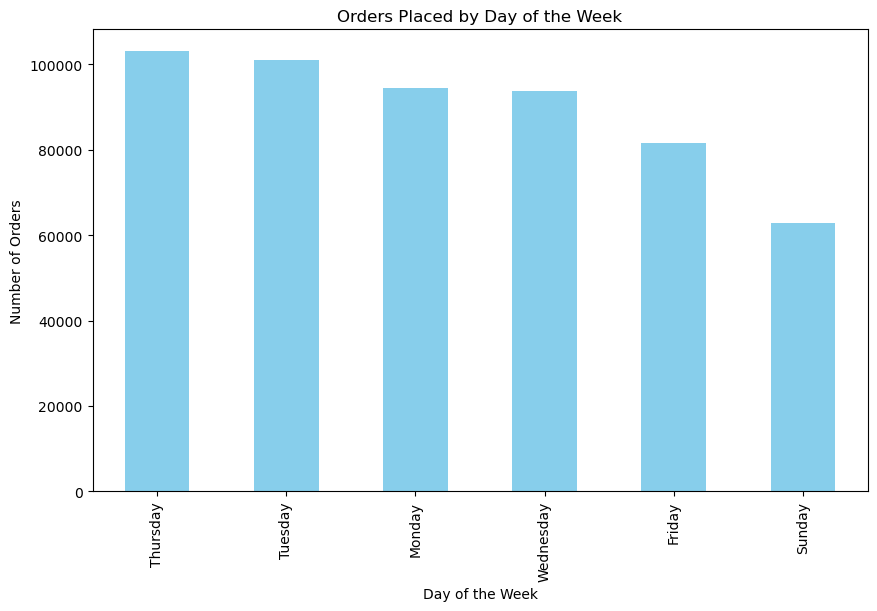

In [35]:
day_of_week_counts = df['Week'].value_counts()

plt.figure(figsize=(10, 6))
day_of_week_counts.plot(kind='bar', color='skyblue')
plt.title('Orders Placed by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

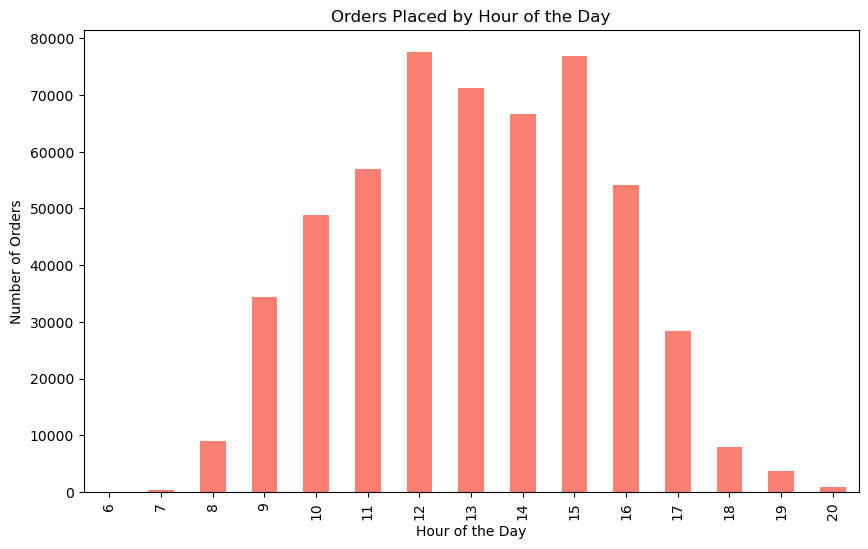

In [36]:
hour_of_day_counts = df['Hour'].value_counts()

plt.figure(figsize=(10, 6))
hour_of_day_counts.sort_index().plot(kind='bar', color='salmon')
plt.title('Orders Placed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

#### b) What is the average order processing time?

In [37]:
df['OrderProcessingTime'] = df['Order_FulfillmentDate'] - df['InvoiceDate']

average_processing_time = df['OrderProcessingTime'].mean()
days = average_processing_time.days
hours, remainder = divmod(average_processing_time.seconds, 3600)

print(f"The average order processing time is: {days} days and {hours} hours.")

The average order processing time is: 5 days and 11 hours.


#### c) Are there any seasonal trends in the dataset?

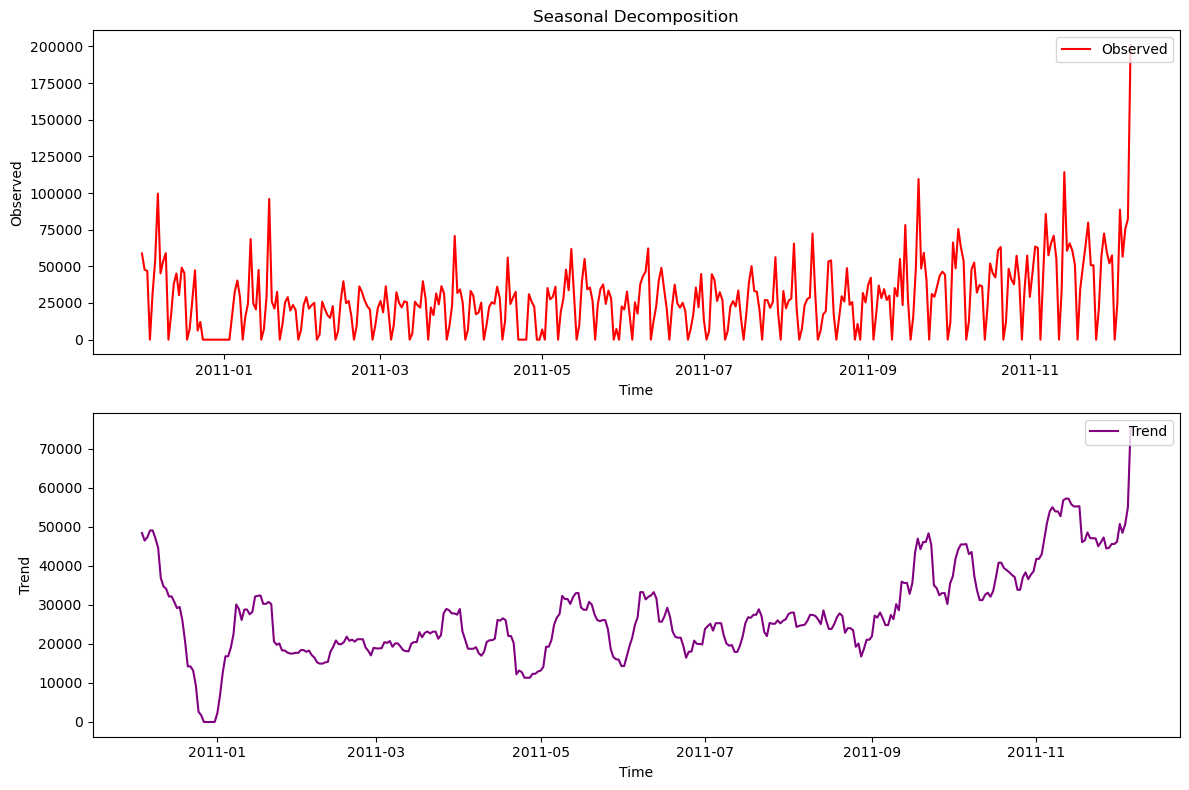

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose


daily_df = df[['Total_Price','InvoiceDate','Quantity', 'UnitPrice']]
daily_df = daily_df[daily_df['Total_Price'] >= 0.0 ]
daily_df.set_index('InvoiceDate', inplace=True)
daily_df = daily_df.resample('D').sum()



result = seasonal_decompose(daily_df['Total_Price'], model='additive')

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(result.observed, label='Observed', color = 'red')
plt.legend(loc='upper right')
plt.ylabel('Observed')
plt.xlabel('Time')
plt.title('Seasonal Decomposition')

plt.subplot(2, 1, 2)
plt.plot(result.trend, label='Trend', color = 'purple')
plt.legend(loc='upper right')
plt.ylabel('Trend')
plt.xlabel('Time')


plt.tight_layout()
plt.show()

### Question 5 - Geographical Analysis

#### a) Can you determine the top 5 countries with the highest number of orders?

In [39]:
# Determining the top 5 countries with the highest number of orders
top_countries = df['Country'].value_counts().head(5)
print("Top 5 countries with the highest number of orders:\n", top_countries)

Top 5 countries with the highest number of orders:
 United Kingdom    490300
Germany             9480
France              8541
EIRE                8184
Spain               2528
Name: Country, dtype: int64


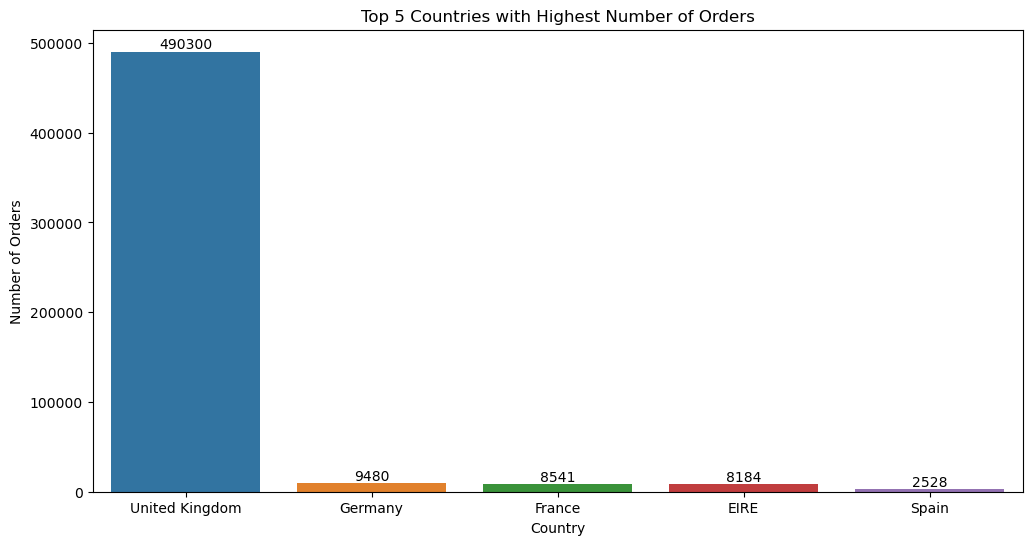

In [40]:
# Visualizing top countries by order count
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 5 Countries with Highest Number of Orders')
plt.xlabel('Country')
plt.ylabel('Number of Orders')

for index, value in enumerate(top_countries.values):
    bar_plot.text(index, value, str(value), ha="center", va="bottom")

plt.show()

#### b) Is there a correlation between the country of the customer and the average order value?

Correlation between country and average order value: -0.47356853272739013


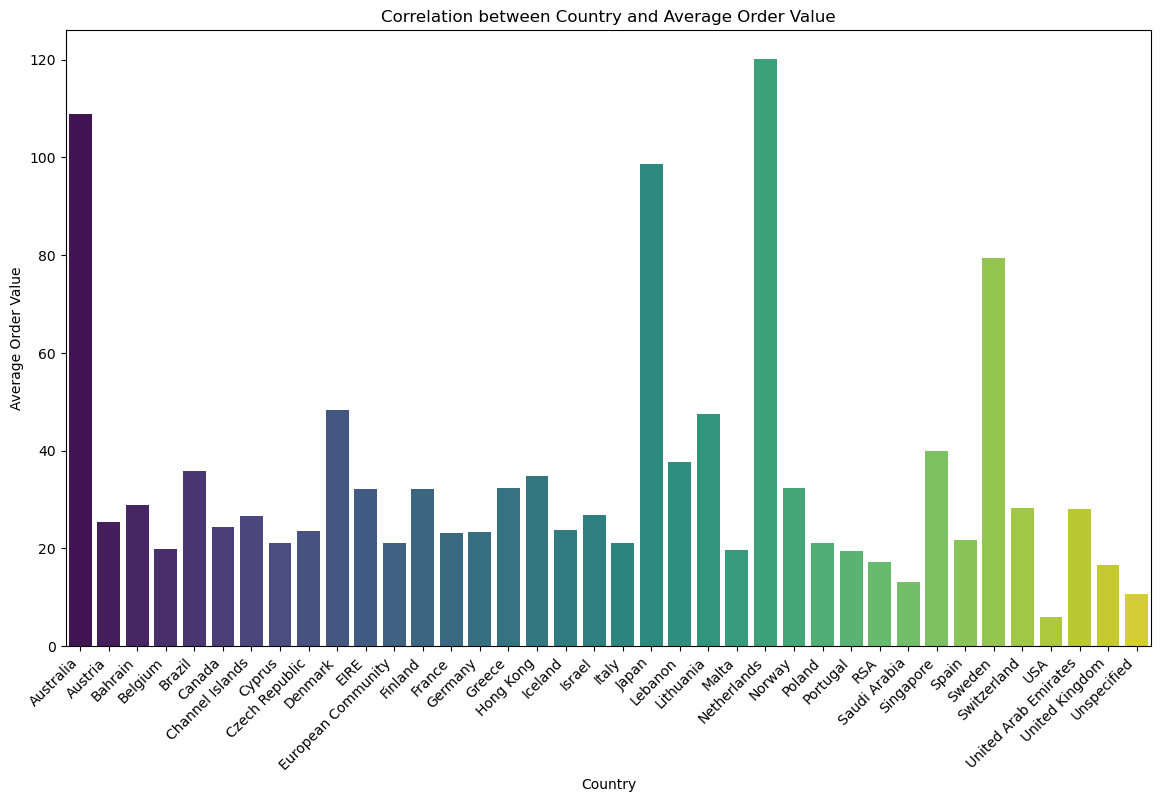

In [41]:
import pandas as pd
from scipy.stats import pointbiserialr

# Calculating the total order value for each row
df['TotalOrderValue'] = df['Quantity'] * df['UnitPrice']

# Calculating average order value per country
avg_order_value_by_country = df.groupby('Country')['TotalOrderValue'].mean()

# Mapping average order values to original DataFrame
df['AvgOrderValueByCountry'] = df['Country'].map(avg_order_value_by_country)

# Converting 'Country' to categorical codes
df['CountryCodes'] = df['Country'].astype('category').cat.codes

# Calculating point biserial correlation coefficient
correlation_country_order_value, _ = pointbiserialr(df['CountryCodes'], df['AvgOrderValueByCountry'])

print("Correlation between country and average order value:", correlation_country_order_value)

# Calculating average order value by country
avg_order_by_country = df.groupby('Country')['TotalOrderValue'].mean().reset_index()

# Bar plot for correlation visualization
plt.figure(figsize=(14, 8))
sns.barplot(x='Country', y='TotalOrderValue', data=avg_order_by_country, palette='viridis')
plt.title('Correlation between Country and Average Order Value')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Negative Correlation:

The negative sign indicates a negative correlation.
As the values of the 'Country' variable increases, the average order value tends to decrease, and vice versa.

#### Strength of Correlation:

The magnitude of the correlation coefficient is -0.4705.
This value is moderate in strength.
It suggests a discernible but not extremely strong relationship between the 'Country' variable and the average order value.

#### Interpretation:

The negative correlation suggests that there is a tendency for certain countries to have lower average order values.
In other words, customers from certain countries (Eg. USA, Saudi Arabia, United Kingdom etc.) might, on average, make smaller purchases compared to customers from other countries (Eg. Australia, Netherlands etc.).

#### Practical Implications:

1. This information could be valuable for marketing and sales strategies.
1. It may prompt further investigation into the factors influencing purchasing behavior in different countries.
1. Tailoring marketing efforts or promotions based on the characteristics of countries with lower average order values could be considered.

### Question 6 - Payment Analysis

#### a) What are the most common payment methods used by customers?

There were no columns in the original dataset which indicated the payment method. In case the data was available, we woud do the analysis in the following way.

Credit card       160910
Cash              106996
PayPal             80882
Wire transfer      80561
Debit card         53738
Mobile payment     53554
Name: PaymentMode, dtype: int64


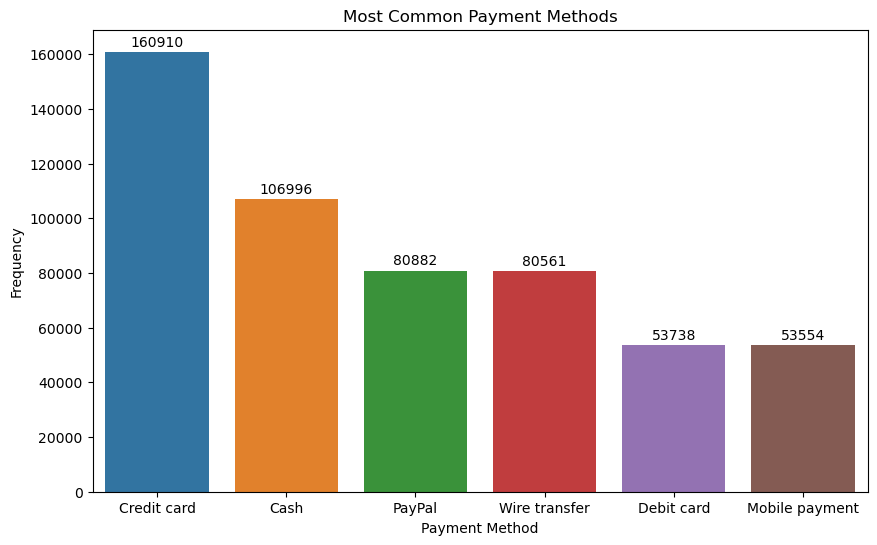

In [42]:
# Calculating most common payment method count
common_payment_methods = df['PaymentMode'].value_counts()
print(common_payment_methods)

# Bar plot for the most common payment methods
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=common_payment_methods.index, y=common_payment_methods.values)
plt.title('Most Common Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Frequency')

for index, value in enumerate(common_payment_methods.values):
    bar_plot.text(index, value + 1000, str(value), ha='center', va='bottom', fontsize=10)

plt.show()

#### Most common payment method :
Credit card is the most common payment method, followed by cash, PayPal, wire transfer, debit card, and mobile payment.

PaymentMode
Cash              18.432822
Credit card       19.266554
Debit card        17.462731
Mobile payment    18.267469
PayPal            17.309315
Wire transfer     16.594472
Name: TotalOrderValue, dtype: float64


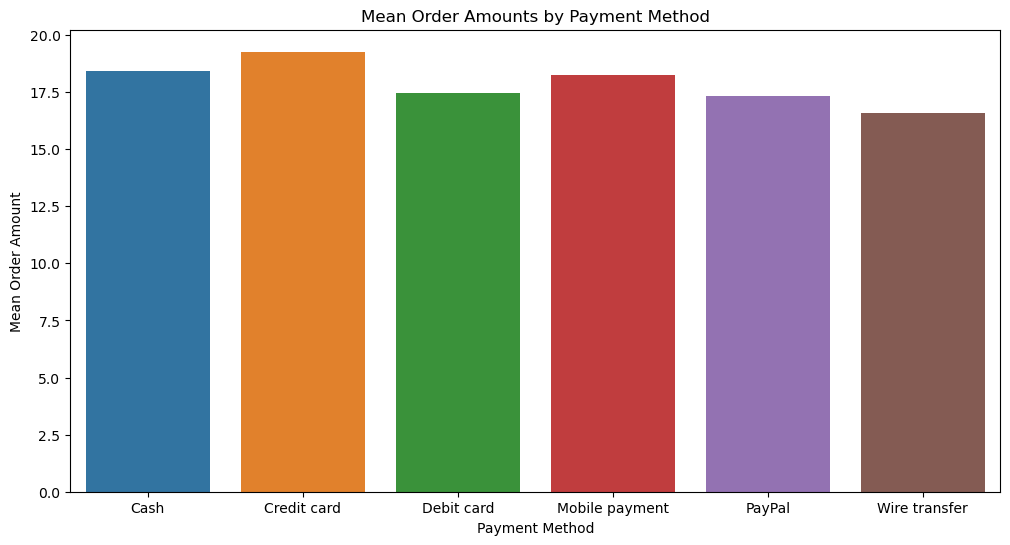

In [43]:
# Relationship between payment method and order amount
mean_order_amounts = df.groupby('PaymentMode')['TotalOrderValue'].mean()

# Displaying mean order amounts for each payment method
print(mean_order_amounts)

# Plotting the relationship using a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_order_amounts.index, y=mean_order_amounts.values)
plt.title('Mean Order Amounts by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Mean Order Amount')
plt.show()

#### b) Is there a relationship between the payment method and the order amount?

#### Payment method and order amount relationship: 
There is a weak positive correlation between payment method and order amount. This means that customers who use debit cards tend to have higher order amounts than customers who use other payment methods.

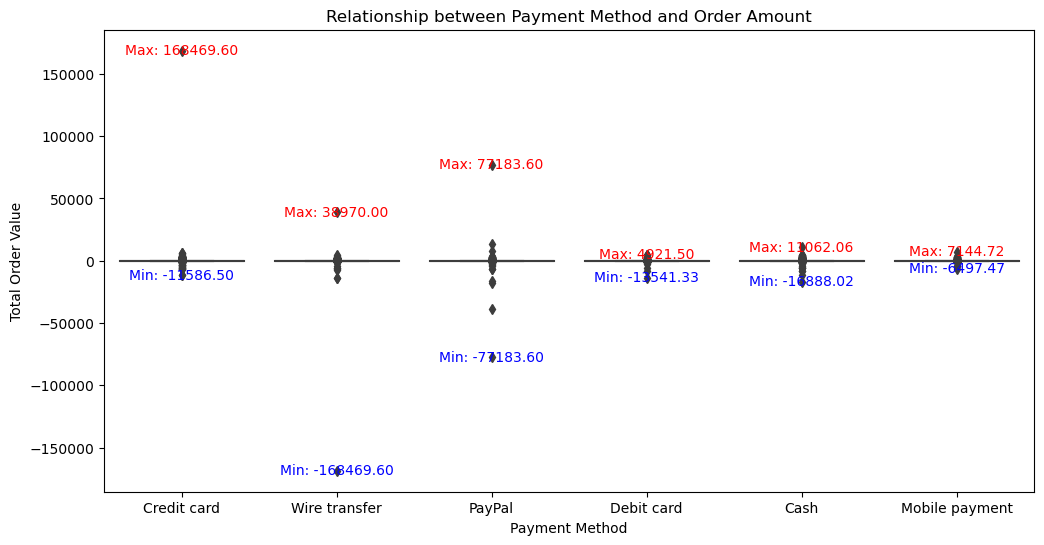

In [44]:
# Plotting the relationship using boxplot

plt.figure(figsize=(12, 6))
sns.boxplot(x='PaymentMode', y='TotalOrderValue', data=df)
plt.title('Relationship between Payment Method and Order Amount')
plt.xlabel('Payment Method')
plt.ylabel('Total Order Value')

# Adding annotations for max and min values

for payment_mode in df['PaymentMode'].unique():
    subset = df[df['PaymentMode'] == payment_mode]
    max_val = subset['TotalOrderValue'].max()
    min_val = subset['TotalOrderValue'].min()

    plt.text(
        df['PaymentMode'].unique().tolist().index(payment_mode),
        max_val + 5,  
        f'Max: {max_val:.2f}',
        ha='center', va='center', color='red'
    )

    plt.text(
        df['PaymentMode'].unique().tolist().index(payment_mode),
        min_val - 5, 
        f'Min: {min_val:.2f}',
        ha='center', va='center', color='blue'
    )

plt.show()

#### Interpretation :

##### 1. Average Order Values:

Users of debit cards tend to exhibit higher spending habits, while credit card and PayPal users show moderate spending patterns.

##### 2. Standard Deviation and Variability:

Debit card transactions showcase diverse spending behaviors, while credit card transactions display varied spending patterns. Other payment modes exhibit lower variability.

##### 3. Minimum and Maximum Order Values:

Debit card transactions show a wide range of spending, including both low and high values. Credit card transactions have a relatively narrow range of total order values.

##### 4. Negative Total Order Values:

Some transactions have negative total order values, especially in the Cash and Mobile payment categories, possibly due to refunds or adjustments.

## Data Processing for K-means Clustering

In [45]:
### Removing Negative Values
df_Kmeans = df

In [46]:
df_Kmeans = df_Kmeans[df_Kmeans.Quantity > 0]
df_Kmeans = df_Kmeans[df_Kmeans.UnitPrice > 0]#Removing the Null values from the data.
df_Kmeans = df_Kmeans[df_Kmeans.CustomerID > 0]
df_Kmeans = df_Kmeans[pd.notnull(df_Kmeans['CustomerID'])]

In [47]:
df_Kmeans['InvoiceDate'] = pd.to_datetime(df_Kmeans['InvoiceDate'])
df_Kmeans['InvoiceYearMonth'] = df_Kmeans['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_Kmeans['Date'] = df_Kmeans['InvoiceDate'].dt.strftime('%Y-%m')

In [48]:
df_Kmeans.isnull().mean()

InvoiceNo                 0.0
StockCode                 0.0
Description               0.0
Quantity                  0.0
InvoiceDate               0.0
UnitPrice                 0.0
CustomerID                0.0
Country                   0.0
CostPrice                 0.0
Customer Feedback         0.0
PaymentMode               0.0
Order_FulfillmentDate     0.0
Total_Price               0.0
Week                      0.0
Hour                      0.0
OrderProcessingTime       0.0
TotalOrderValue           0.0
AvgOrderValueByCountry    0.0
CountryCodes              0.0
InvoiceYearMonth          0.0
Date                      0.0
dtype: float64

We have all the crucial information we need:
- Customer ID
- Unit Price
- Quantity
- Invoice Date

In [49]:
df_Kmeans['Revenue'] = df_Kmeans['Quantity'] * df_Kmeans['UnitPrice']

In [50]:
df_revenue_K = df_Kmeans.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()

### Question 7 - Customer Behavior

#### a) How long, on average, do customers remain active (between their first and last purchase)?

In [51]:
df_Kmeans['InvoiceDate'] = pd.to_datetime(df_Kmeans['InvoiceDate'])
customer_activity_duration = df_Kmeans.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_activity_duration['Duration'] = (customer_activity_duration['max'] - customer_activity_duration['min']).dt.days
average_customer_activity_duration = customer_activity_duration['Duration'].mean()

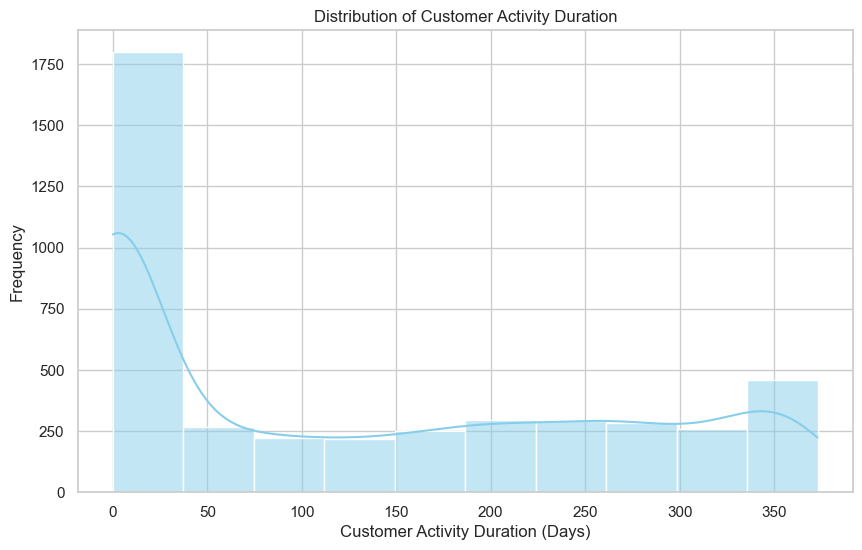

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(customer_activity_duration['Duration'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Customer Activity Duration')
plt.xlabel('Customer Activity Duration (Days)')
plt.ylabel('Frequency')
plt.show()

From the above graph, we can see that  the majority of customers tend to make purchases relatively frequently, with the average duration between two purchases typically falling within the 40 days. This suggests that a significant portion of customers engages with the business on a regular basis, possibly indicating consistent or periodic purchasing behavior. Understanding this pattern can be valuable for tailoring marketing strategies and promotions to maintain and enhance customer engagement, encouraging repeat purchases within a relatively short timeframe.

#### b) Are there any customer segments based on their purchase behavior?

To find if there are any segments on their purchase behaviour, we will perform RFM Analysis and then use K-means to find the clusters of customers.

### Task 2: RFM Calculation

In [53]:
# Defining the last date as the most recent date
NOW = dt.date(2011,12,9) 
df_Kmeans['Date'] = pd.DatetimeIndex(df_Kmeans.InvoiceDate).date

#### Recency

In [54]:
df_recency = df_Kmeans.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','LastPurchaseDate']

print(NOW)

df_recency['Recency'] = df_recency.LastPurchaseDate.apply(lambda x:(NOW - x).days)
df_recency.head()

2011-12-09


,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


#### Frequency-Monetary

In [55]:
FM_Table = df_Kmeans.groupby('CustomerID').agg({'InvoiceNo' : lambda x:len(x), 
                                         'Revenue': lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' : 'Frequency', 
                           'Revenue': 'Monetary'},inplace=True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12347.0,182,4310.00
12348.0,31,1797.24
12349.0,73,1757.55
12350.0,17,334.40


#### RFM Table

In [56]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table = RFM_Table[['CustomerID','Recency','Frequency','Monetary']]
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40


### Task 3: RFM Segmentation:

In [57]:
segmented_rfm = RFM_Table

In [58]:
# Calculate quartiles
quartiles = segmented_rfm[['Recency', 'Frequency', 'Monetary']].quantile(q=[0.25, 0.5, 0.75])

# Convert quartiles to a dictionary for easy access
quartiles = quartiles.to_dict()

In [59]:
# Function to assign quartile scores
def R_score(value, metric):
    if value <= quartiles[metric][0.25]:
        return 1
    elif value <= quartiles[metric][0.5]:
        return 2
    elif value <= quartiles[metric][0.75]:
        return 3
    else:
        return 4

    # Function to assign quartile scores
def FM_score(value, metric):
    if value <= quartiles[metric][0.25]:
        return 4
    elif value <= quartiles[metric][0.5]:
        return 3
    elif value <= quartiles[metric][0.75]:
        return 2
    else:
        return 1

# Apply the quartile scoring function to each row
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(lambda x: R_score(x, 'Recency'))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(lambda x: FM_score(x, 'Frequency'))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(lambda x: FM_score(x, 'Monetary'))

In [60]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12347.0,2,182,4310.00,1,1,1,111,3
2,12348.0,75,31,1797.24,3,3,1,331,7
3,12349.0,18,73,1757.55,2,2,1,221,5
4,12350.0,310,17,334.40,4,4,3,443,11


RFM segmentation readily shows customer for any business like Best Customers, Loyal Customer, Customers on the verge of losing, Highest revenue-generating customers etc.

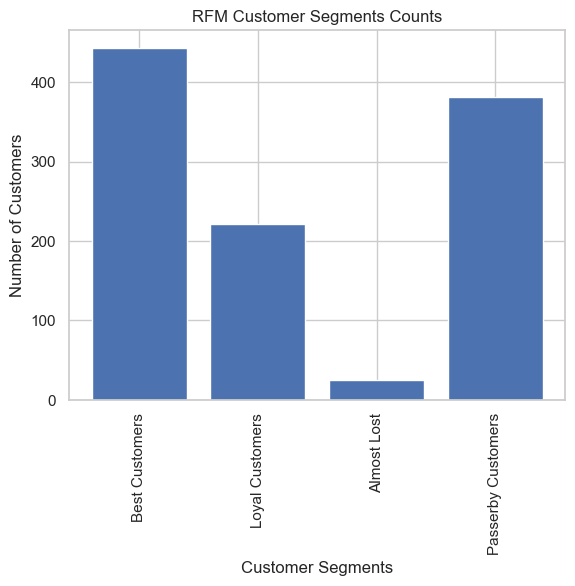

In [61]:
customer_segments = {
    'Best Customers': ['RFM_Segment', '111'],
    'Loyal Customers': ['RFM_Segment', '211'],
    'Almost Lost': ['RFM_Segment', '134'],
    'Passerby Customers': ['RFM_Segment', '444']
}

# Count the number of customers in each segment
segment_counts = {segment: len(segmented_rfm[segmented_rfm[condition[0]] == condition[1]])
                  for segment, condition in customer_segments.items()}
# Create a bar plot
plt.bar(segment_counts.keys(), segment_counts.values())
plt.xlabel('Customer Segments')
plt.ylabel('Number of Customers')
plt.title('RFM Customer Segments Counts')
plt.xticks(rotation=90)
plt.show()

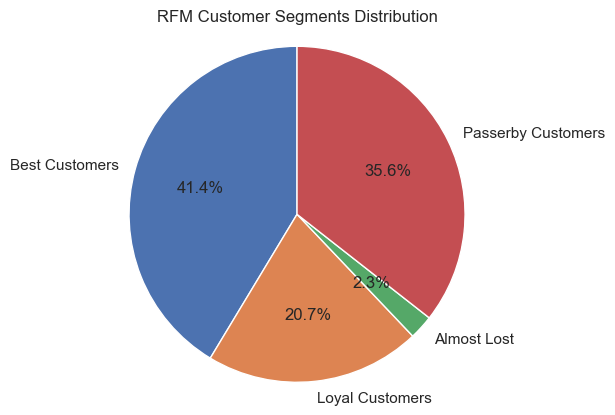

In [62]:
# Create a pie chart
plt.pie(segment_counts.values(), labels=segment_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('RFM Customer Segments Distribution')

plt.show()

### Task 4: Customer Segmentation:

K-means Clustering gives the best result under the following conditions:
- Data’s distribution is not skewed
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

Checking the Skewness of the data

In [63]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

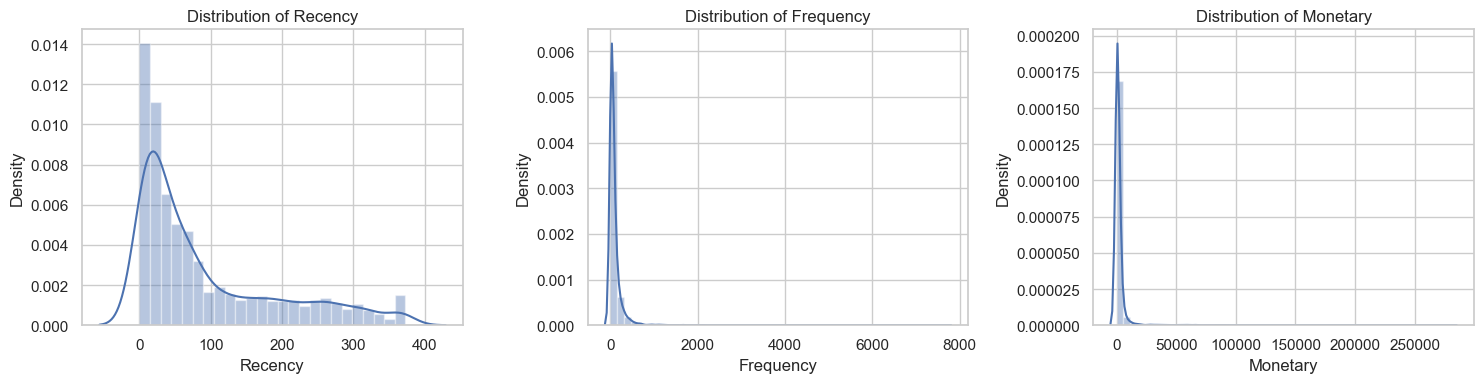

In [64]:
plt.figure(figsize=(15, 4))
# Subplot 1: Histogram
plt.subplot(1, 3, 1)
plt.title('Distribution of Recency')
sns.distplot(RFM_Table['Recency'], kde=True)

# Subplot 2: Distribution Plot
plt.subplot(1, 3, 2)
plt.title('Distribution of Frequency')
sns.distplot(RFM_Table['Frequency'])

# Subplot 3: Probability Plot (Quantile-Quantile Plot)
plt.subplot(1, 3, 3)
plt.title('Distribution of Monetary')
sns.distplot(RFM_Table['Monetary'])

plt.tight_layout()
plt.show()

Recency's: Skew: 1.2453948317057284, : SkewtestResult(statistic=26.60351236555474, pvalue=6.181721752536432e-156)


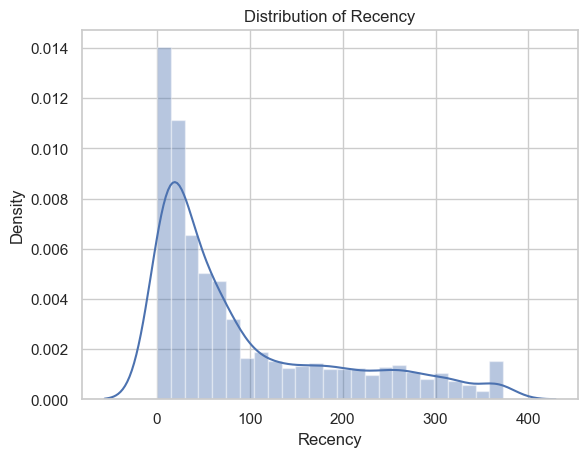

In [65]:
check_skew(RFM_Table,'Recency')

Frequency's: Skew: 18.037289818570194, : SkewtestResult(statistic=83.48409612389142, pvalue=0.0)


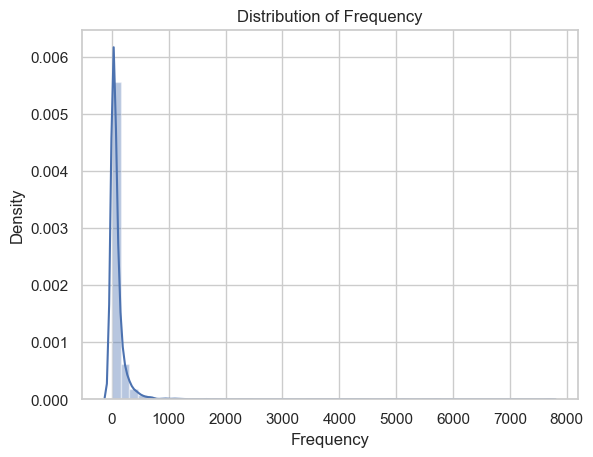

In [66]:
check_skew(RFM_Table,'Frequency')

Monetary's: Skew: 19.332680144099353, : SkewtestResult(statistic=85.01187149828888, pvalue=0.0)


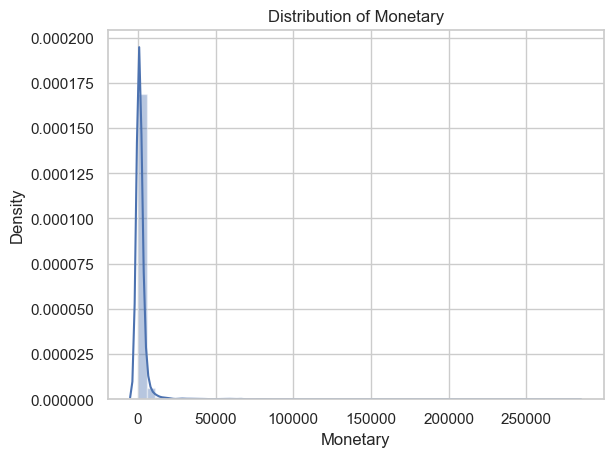

In [67]:
check_skew(RFM_Table,'Monetary')

Removing the skewness in the data

In [68]:
RFM_Table_int = RFM_Table[['CustomerID',  'Recency','Frequency', 'Monetary']].astype(int)
df_rfm_log = np.log(RFM_Table_int)
df_rfm_log.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaN or infinite values
if df_rfm_log.isin([np.nan, np.inf, -np.inf]).any().any():
    # Fill NaN values with a specific value or method (e.g., mean, median)
    df_rfm_log.fillna(0, inplace=True)  # Replace NaN with 0, adjust as needed

    # Convert the DataFrame to integers
    df_rfm_log_int = df_rfm_log.astype(int)

    # Display the DataFrame with integer values
#     print(df_rfm_log_int)
else:
    print("No NaN or infinite values found.")

After Removing Skewness

Recency's: Skew: -0.6094511820350134, : SkewtestResult(statistic=-15.186133875478827, pvalue=4.369416788985696e-52)
Frequency's: Skew: -0.21789311915893791, : SkewtestResult(statistic=-5.801761082598964, pvalue=6.5622020042075114e-09)
Monetary's: Skew: 0.3768102405671916, : SkewtestResult(statistic=9.821361151191898, pvalue=9.110498488559356e-23)


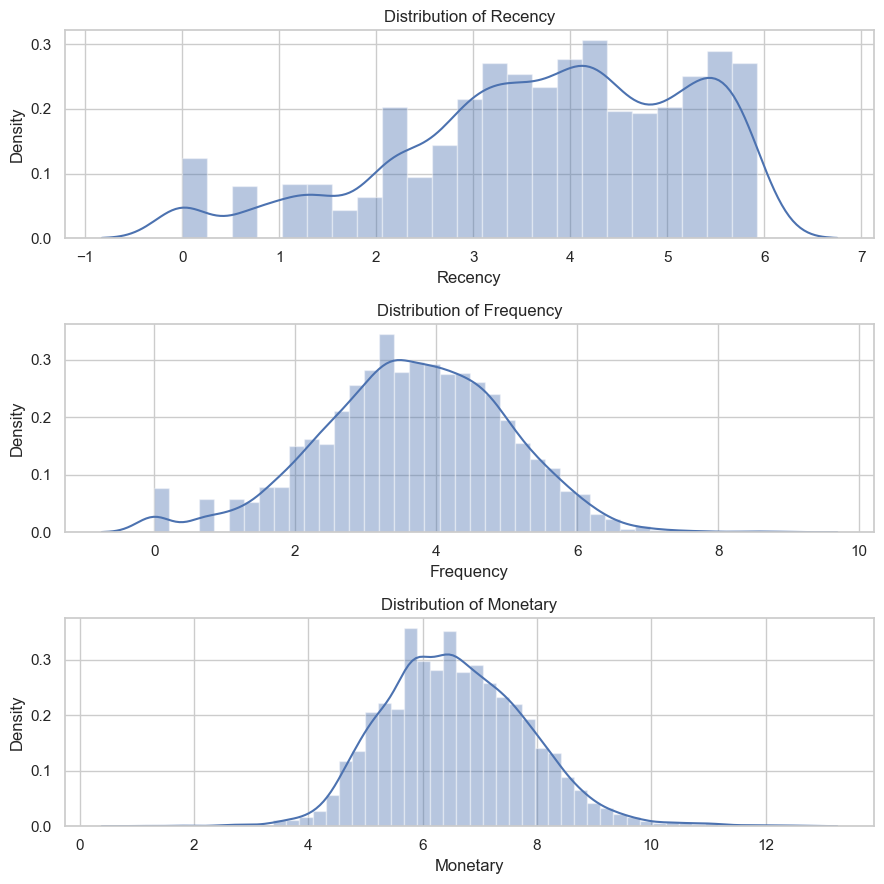

In [69]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')
plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')
plt.tight_layout()

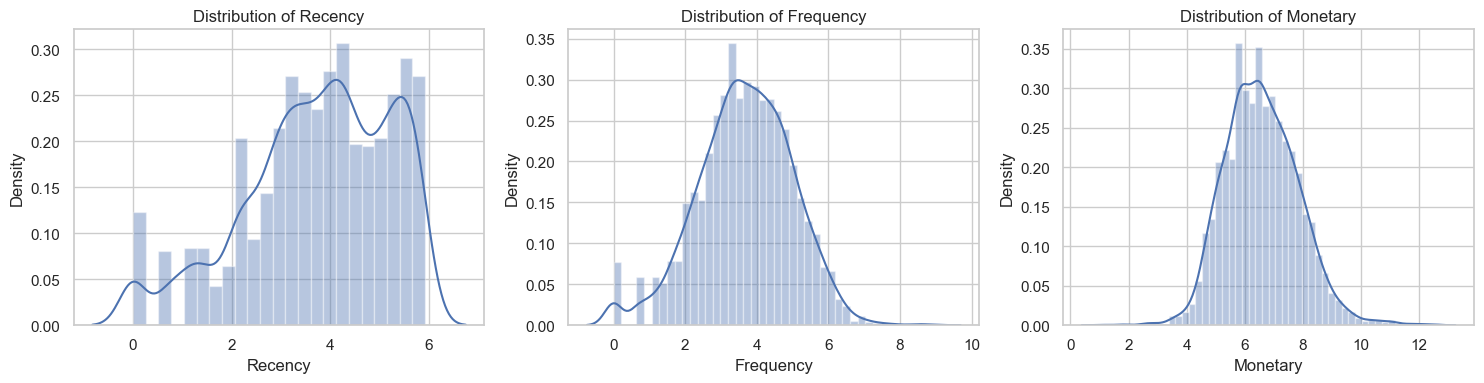

In [70]:
plt.figure(figsize=(15, 4))
# Subplot 1: Histogram
plt.subplot(1, 3, 1)
plt.title('Distribution of Recency')
sns.distplot(df_rfm_log['Recency'], kde=True)

# Subplot 2: Distribution Plot
plt.subplot(1, 3, 2)
plt.title('Distribution of Frequency')
sns.distplot(df_rfm_log['Frequency'])

# Subplot 3: Probability Plot (Quantile-Quantile Plot)
plt.subplot(1, 3, 3)
plt.title('Distribution of Monetary')
sns.distplot(df_rfm_log['Monetary'])

plt.tight_layout()
plt.show()

Scaling the data

In [71]:
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_Table_scaled = scaler.transform(df_rfm_log)

In [72]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns = df_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-1.833344,1.388122,-2.779978,3.696407
1,-1.832631,-2.064513,1.160356,1.412487
2,-1.831918,0.393612,-0.179855,0.719991
3,-1.831204,-0.574296,0.468643,0.702172
4,-1.830491,1.356073,-0.634745,-0.612038


In [73]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

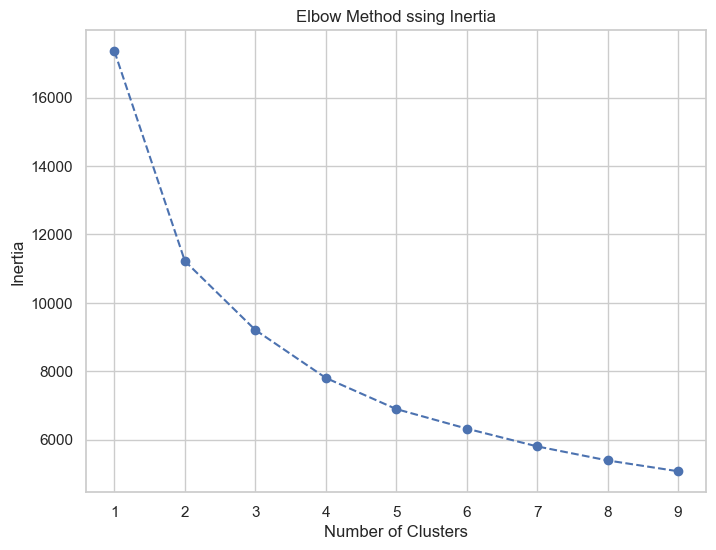

In [74]:
# Plot the Elbow Method graph to determine the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(K, inertias, marker='o', linestyle='--')
plt.title('Elbow Method ssing Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [75]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

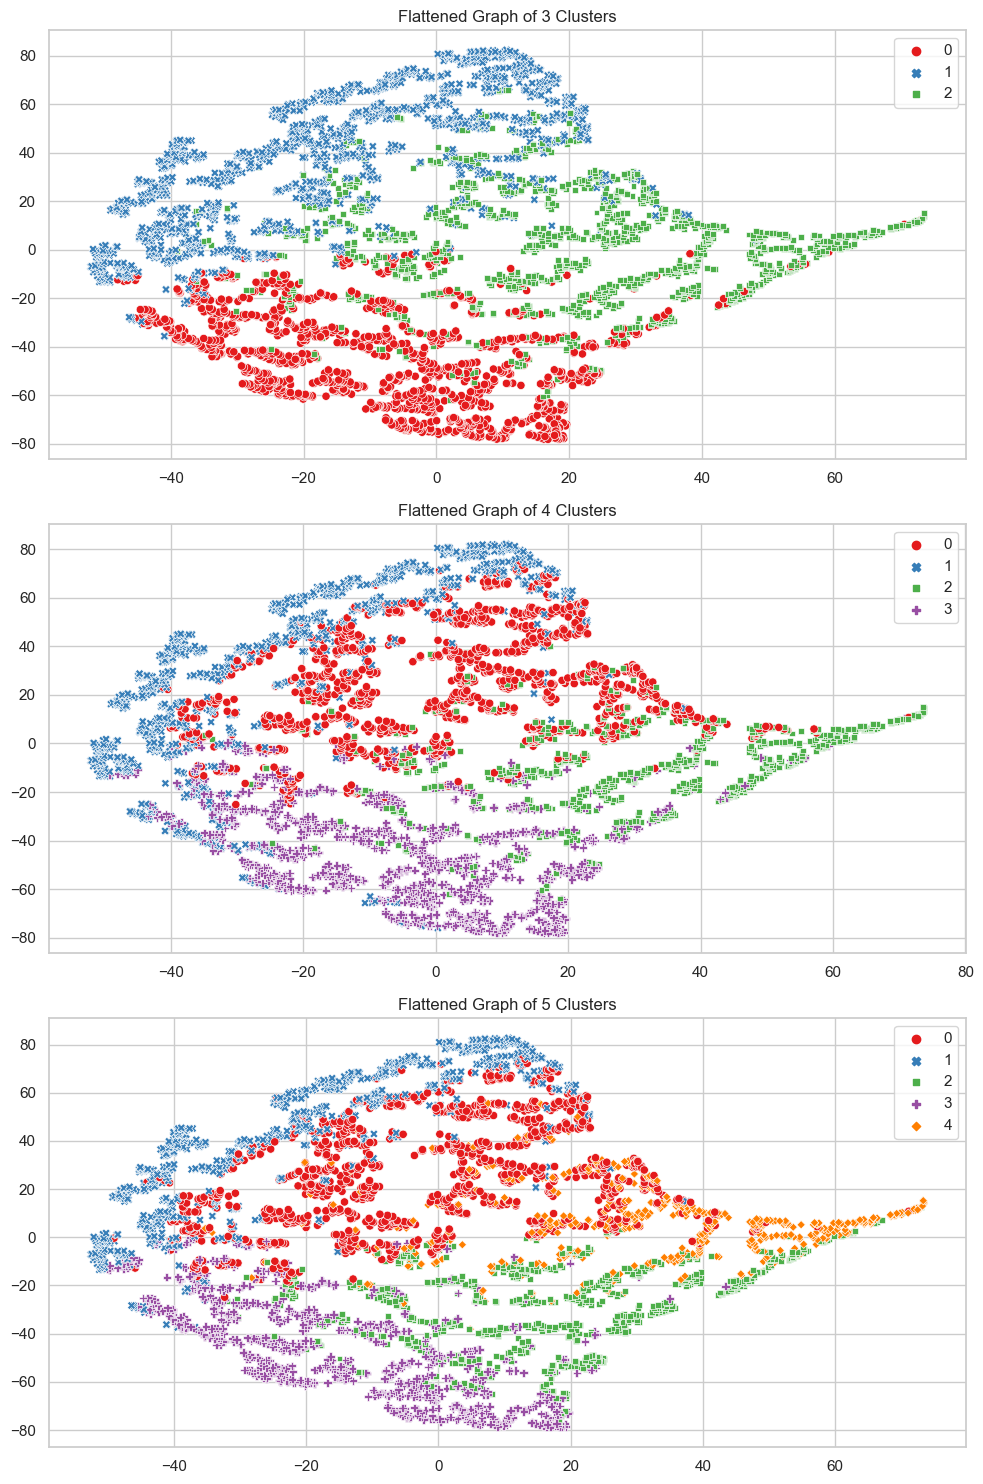

In [76]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)
plt.tight_layout()

### Task 5: Segment Profiling

In [77]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    # Sort by ascending recency
    df_new = df_new.sort_values(by=('Recency', 'mean'), ascending=True)

    return df_new

rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
2          15.0     265.0   6987.0   850
0          52.0      89.0   1388.0  1222
3         118.0      35.0    795.0  1201
1         170.0      15.0    279.0  1065

#### Cluster 2 - Best Customers
Customers in this cluster can be interpreted as “Best Customers” segment as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).

#### Cluster 0 - Loyal Customers
Customers in this cluster can be interpreted as very Loyal Customers and they also spent a lot.

#### Cluster 3 - Almost Lost Customers
Customers in this cluster can be interpreted as “Almost Lost” customers as they Haven’t purchased for some time(R=3) but used to purchase frequently and spent a lot.

#### Cluster 1 - Passerby Customer
Customers in this cluster can be interpreted as passerby customers as their last purchase is long ago (R=4), purchased very few (F=4) and spent little (M=4). The company has to come up with new strategies to make them permanent members.

In [78]:
# Assuming 'segmented_rfm' is your DataFrame with RFM scores and 'df_rfm_k3' is the DataFrame with cluster labels

# Add the cluster labels to the 'segmented_rfm' DataFrame
segmented_rfm['Cluster'] = df_rfm_k4['Cluster']

# Profile and analyze each customer segment
for cluster_number in range(4):
    # Filter the DataFrame based on the cluster label
    cluster_df = segmented_rfm[segmented_rfm['Cluster'] == cluster_number]

    # Display information about the current cluster
    print(f"Cluster: {cluster_number}")
    print(f"Number of Customers: {len(cluster_df)}")

    # Display RFM statistics for the cluster
    print("RFM Statistics:")
    print(cluster_df[['Recency', 'Frequency', 'Monetary']].describe())

    # You can add more code here to analyze additional attributes specific to your data

    # Add a line break for better readability
    print("\n" + "=" * 50 + "\n")

Cluster: 0
Number of Customers: 1222
RFM Statistics:
           Recency    Frequency      Monetary
count  1222.000000  1222.000000   1222.000000
mean     52.281506    89.297054   1388.440868
std      55.462239    71.618330   1721.399042
min       1.000000     1.000000    120.030000
25%      17.000000    42.000000    613.205000
50%      32.000000    69.000000    992.030000
75%      66.000000   115.000000   1706.802500
max     372.000000   544.000000  44534.300000


Cluster: 1
Number of Customers: 1065
RFM Statistics:
           Recency    Frequency     Monetary
count  1065.000000  1065.000000  1065.000000
mean    169.896714    14.915493   279.029569
std     112.216387    12.370699   265.896778
min       2.000000     1.000000     3.750000
25%      64.000000     6.000000   135.400000
50%     166.000000    12.000000   217.900000
75%     262.000000    21.000000   336.130000
max     373.000000    96.000000  4055.720000


Cluster: 2
Number of Customers: 850
RFM Statistics:
          Recency  

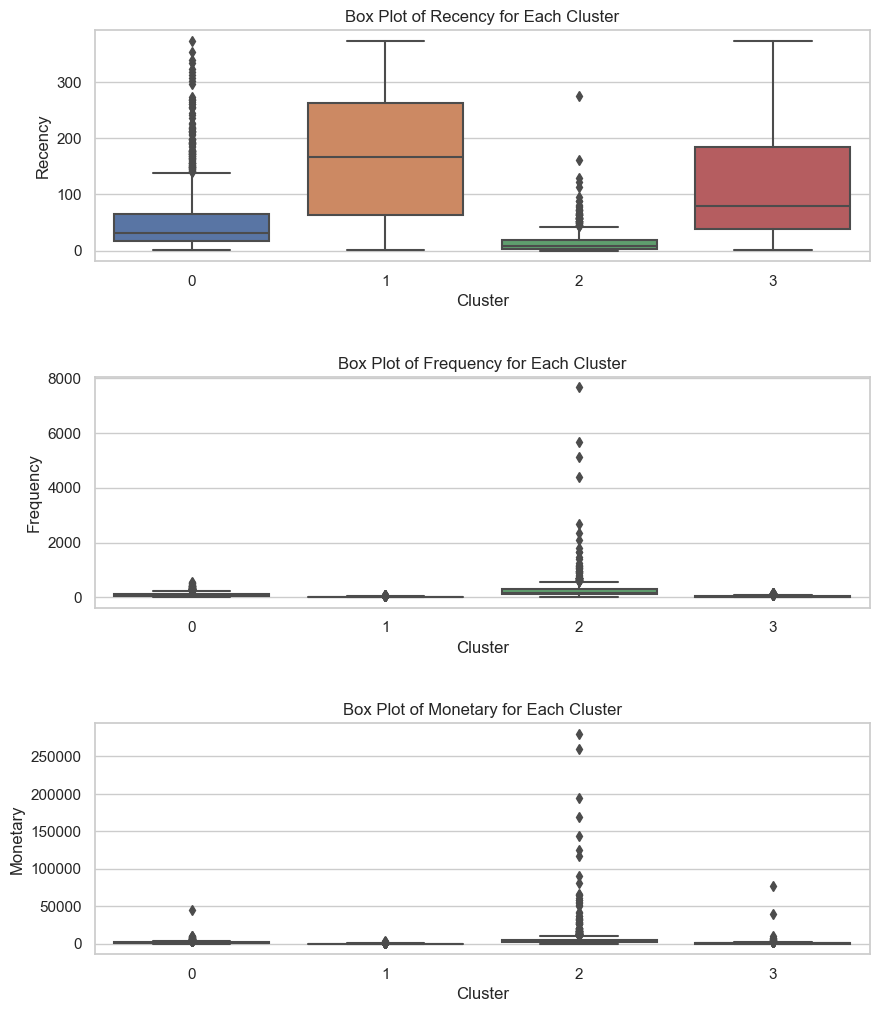

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add the cluster labels to the 'segmented_rfm' DataFrame
segmented_rfm['Cluster'] = df_rfm_k4['Cluster']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)

# Plot box plots for Recency, Frequency, and Monetary values for each cluster
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.boxplot(x='Cluster', y=metric, data=segmented_rfm, ax=axes[i])
    axes[i].set_title(f'Box Plot of {metric} for Each Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)

# Show the plot
plt.show()

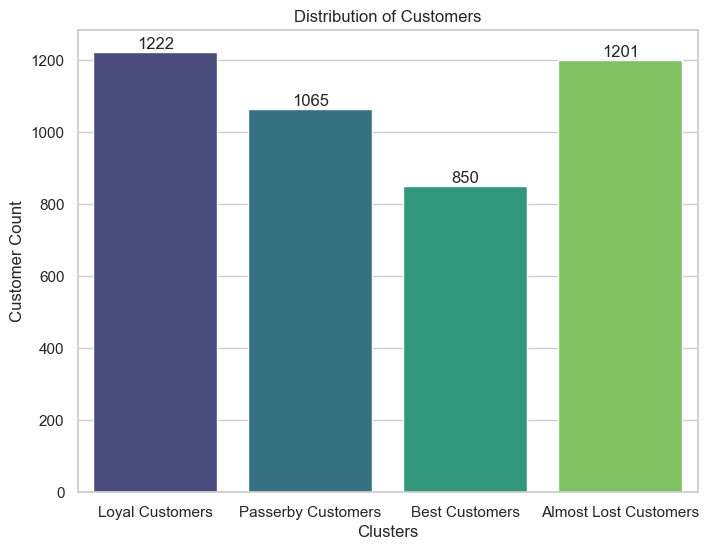

In [80]:
cluster_counts = df_rfm_k4['Cluster'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
g = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

g.set_xticklabels(['Loyal Customers', 'Passerby Customers', 'Best Customers','Almost Lost Customers'])
g.bar_label(g.containers[0])

plt.title('Distribution of Customers')
plt.xlabel('Clusters')
plt.ylabel('Customer Count')
plt.show()

### Task 6: Marketing Recommendations

Cluster 0 - Loyal Customers

Marketing Strategy:

- Maintain Engagement: Regularly communicate with personalized messages, exclusive offers, and product updates to maintain their loyalty.
- Subscription Services: Introduce subscription services for products they frequently purchase to ensure consistent revenue.
- Special Promotions: Offer special promotions and discounts to show appreciation for their continued loyalty.


Cluster 1 - Passerby Customers

Marketing Strategy:
- Re-Engagement Campaigns: Launch targeted re-engagement campaigns to bring them back as active customers.
- Limited-Time Offers: Provide limited-time offers or discounts to incentivize a new purchase and capture their interest.
- Remarketing Strategies: Utilize remarketing strategies, such as email campaigns and social media ads, to stay top-of-mind.

Cluster 2 - Best Customers

Marketing Strategy:
- Exclusive Loyalty Program: Recognize and reward their loyalty with an exclusive loyalty program offering early access, special discounts, and personalized perks.
- Personalized Recommendations: Leverage their frequent purchase history to provide personalized product recommendations and offers.
- VIP Events: Invite them to VIP events, product launches, or private sales to enhance their sense of exclusivity.

Cluster 3 - Almost Lost Customers

Marketing Strategy:
- Win-Back Campaigns: Implement targeted win-back campaigns with attractive discounts or incentives to encourage them to return.
- Reactivation Offers: Send personalized reactivation offers based on their previous purchase history to rekindle their interest.
- Customer Feedback: Gather feedback to understand the reasons behind their decreased frequency and tailor strategies accordingly.

### Question 8 - Returns and Refunds

#### a) What is the percentage of orders that have experienced returns or refunds?

We have assumed that the 'Quantity' column have negative values which indicate the returns or refunds.

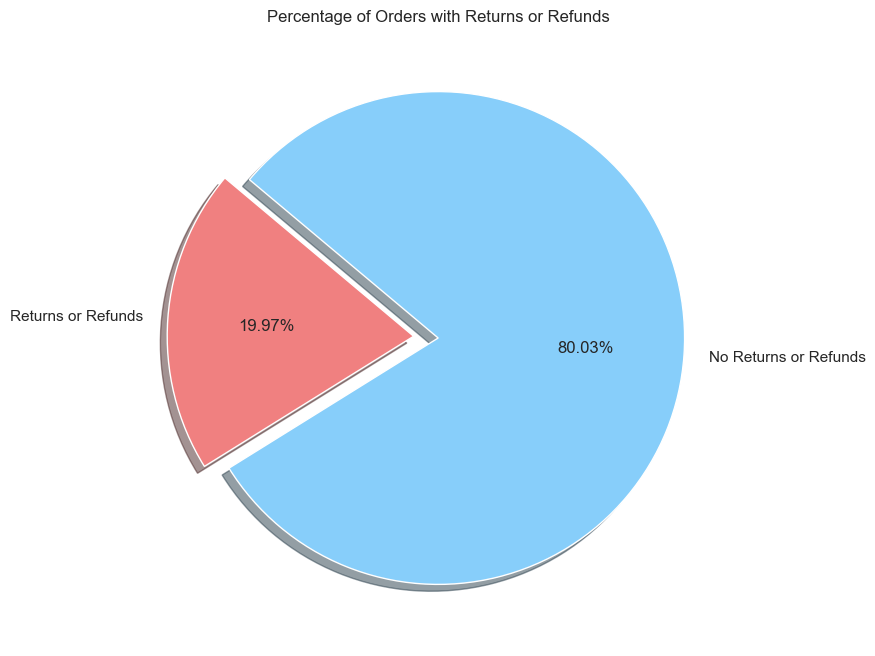

In [81]:
# The 'Quantity' column may have negative values for returns or refunds

# Calculate the percentage of orders with returns or refunds
returns_refunds_percentage = (df[df['Quantity'] < 0]['InvoiceNo'].nunique() / df['InvoiceNo'].nunique()) * 100
no_returns_refunds_percentage = 100 - returns_refunds_percentage

# Pie chart
labels = ['Returns or Refunds', 'No Returns or Refunds']
sizes = [returns_refunds_percentage, no_returns_refunds_percentage]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 1st slice (Returns or Refunds)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('Percentage of Orders with Returns or Refunds')
plt.show()

#### b) Is there a correlation between the product category and the likelihood of returns?

There is no column indicating the product category. To show the correlation, we are making a new column product category.

In [82]:
# Defining the categories based on keywords in the descriptions
categories = {
    "Home Decor": ["HOLDER", "LANTERN", "COAT HANGER", "WATER BOTTLE", "NIGHT LIGHT"],
    "Kitchen": ["TEA TOWELS", "MUG", "TEASPOONS", "JIGSAW BLOCKS", "RECIPE BOX"],
    "Accessories": ["HOT WATER BOTTLE", "COSY", "UMBRELLA", "JEWELRY", "HAIR GRIP"],
    "Stationery": ["NOTEBOOK", "PENCILS", "PENS", "RIBBONS", "CARD"],
    "Toys": ["TOY", "DOLL", "PUZZLES", "SKIPPING ROPE", "SKITTLES"],
    "Christmas": ["CHRISTMAS", "BAUBLES", "DECORATION", "RIBBON", "ADVENT CALENDAR"],
    "Jewellery": ['RING','PENDANT',"BRACELET"]
}

# Function to assign category based on keywords
def assign_category(description):
    for category, keywords in categories.items():
#         print(keywords)
        if any(keyword in description for keyword in keywords):
            return category
        if description.islower():
            return 'Possible Return item'
    return "Other"  # If no category is matched

# Applying the function to create the 'Category' column
df["Category"] = df["Description"].apply(assign_category)

# Displaying the DataFrame
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CostPrice,Customer Feedback,PaymentMode,Order_FulfillmentDate,Total_Price,Week,Hour,OrderProcessingTime,TotalOrderValue,AvgOrderValueByCountry,CountryCodes,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.812711,Fast shipping.,Credit card,2010-12-08 08:26:00,15.30,Wednesday,8,7 days,15.30,16.65741,36,Home Decor
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Wire transfer,2010-12-02 08:26:00,20.34,Wednesday,8,1 days,20.34,16.65741,36,Home Decor
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1.954884,Poor quality.,PayPal,2010-12-02 08:26:00,22.00,Wednesday,8,1 days,22.00,16.65741,36,Home Decor
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Debit card,2010-12-07 08:26:00,20.34,Wednesday,8,6 days,20.34,16.65741,36,Home Decor
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2.409839,Excellent customer service.,Cash,2010-12-02 08:26:00,20.34,Wednesday,8,1 days,20.34,16.65741,36,Other


There are a lot of items with the description in lower case which indicate that they are returned or refunded items. But for this usecase, we will be ignoring those values and deal with the items with description of the product type only.

In [83]:
df_prod_desc_only = df[df['Category']!='Possible Return item']

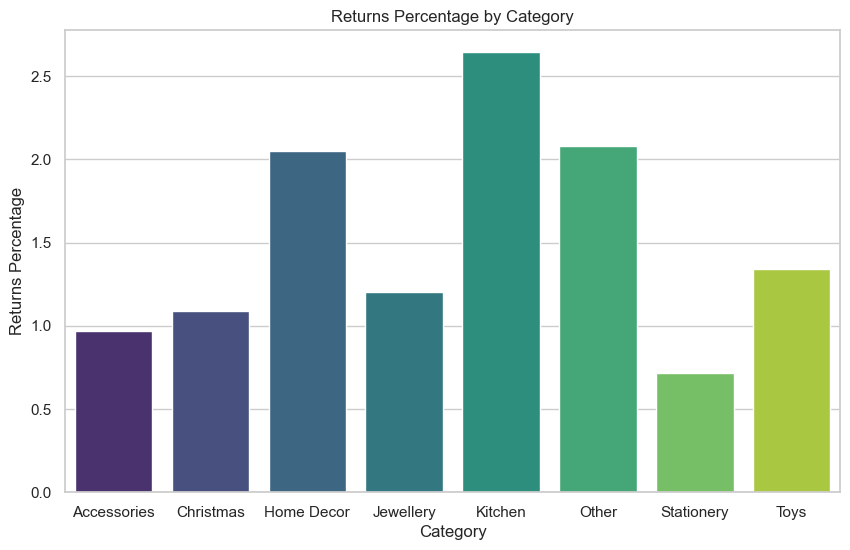

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Category' and 'Description' columns

# Filter only rows with returns
returns_df = df_prod_desc_only[df_prod_desc_only['Quantity'] < 0]

# Group by Category to get returns count for each category
returns_by_category = returns_df.groupby('Category')['InvoiceNo'].count()

# Calculate the total orders for each category
total_orders_by_category = df_prod_desc_only.groupby('Category')['InvoiceNo'].count()

# Calculate the percentage of returns for each category
returns_percentage_by_category = (returns_by_category / total_orders_by_category) * 100

# Create a DataFrame for returns analysis
returns_analysis = pd.DataFrame({
    'Returns Count': returns_by_category,
    'Returns Percentage': returns_percentage_by_category
})

# Plot bar chart for returns percentage by category
plt.figure(figsize=(10, 6))
sns.barplot(x=returns_analysis.index, y='Returns Percentage', data=returns_analysis, palette='viridis')
plt.title('Returns Percentage by Category')
plt.xlabel('Category')
plt.ylabel('Returns Percentage')
plt.show()

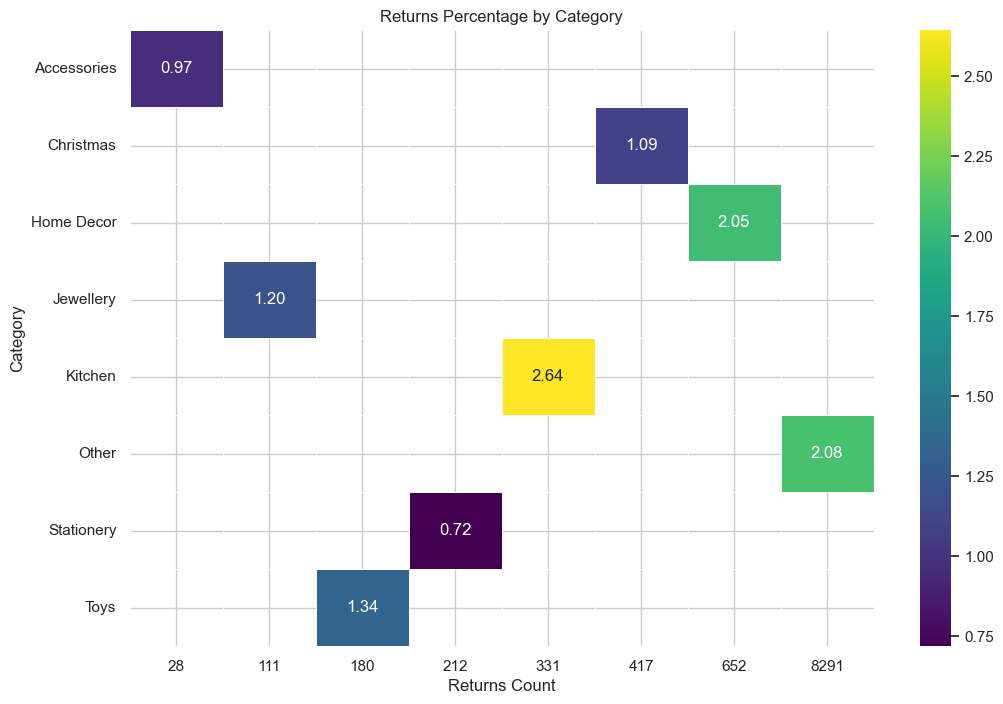

In [85]:
# Reset index to make 'Category' a column for heatmap
returns_analysis = returns_analysis.reset_index()

# Pivot the DataFrame for heatmap
heatmap_data = returns_analysis.pivot('Category', 'Returns Count', 'Returns Percentage')

# Plot heatmap for returns percentage by category
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Returns Percentage by Category')
plt.xlabel('Returns Count')
plt.ylabel('Category')
plt.show()

### Question 9 - Profitability Analysis

#### a) Can you calculate the total profit generated by the company during the dataset's time period?

In [86]:
print("Time period of the data varies from", df['InvoiceDate'].min(), "to",df['InvoiceDate'].max())

Time period of the data varies from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [87]:
df_profit = df

# Calculating total amount = quantity * price for each product
df_profit.loc[:, 'SellingPrice'] = df_profit['Quantity'] * df_profit['UnitPrice']
df_profit.loc[:, 'TotalCost'] = df_profit['Quantity'] * df_profit['CostPrice']

df_profit.loc[:, 'Profit'] = df_profit['SellingPrice'] - df_profit['TotalCost']

total_profit = df_profit['Profit'].sum()

print(f"The total profit generated by the company during the dataset's time period is {total_profit:.2f}")

The total profit generated by the company during the dataset's time period is 2812110.50


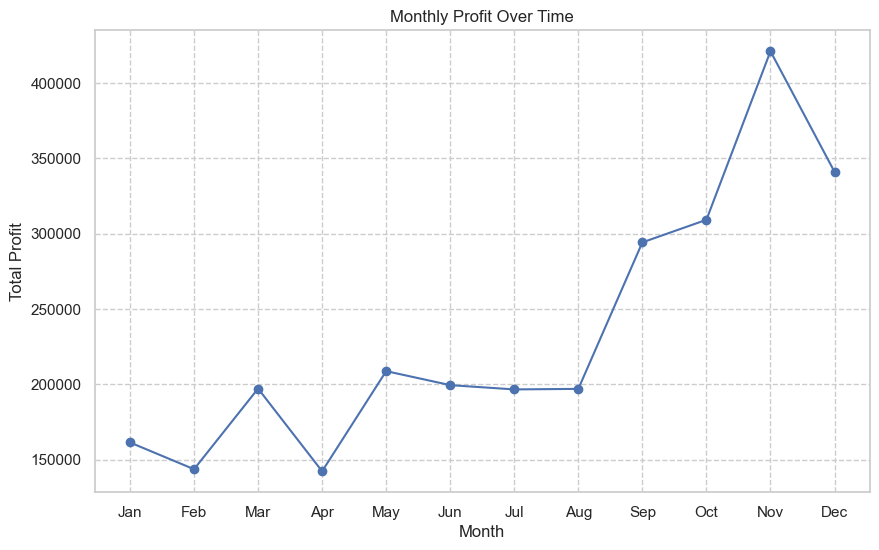

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extracting month abbreviations from the 'InvoiceDate' column
df['Month'] = df['InvoiceDate'].dt.strftime('%b')

# Convert 'Month' to Categorical with desired order
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month'] = pd.Categorical(df['Month'], categories=months_order, ordered=True)

# Calculating profit per month
monthly_profit = df.groupby('Month')['Profit'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_profit['Month'], monthly_profit['Profit'], marker='o', linestyle='-')
plt.title('Monthly Profit Over Time')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.grid(True, linestyle='--')

# Displaying the plot
plt.show()

#### b) What are the top 5 products with the highest profit margins?

In [89]:
# Calculating total profit for each product
product_profit = df_profit.groupby('Description')['Profit'].sum()

# Calculating total revenue for each product
product_revenue = df_profit.groupby('Description')['UnitPrice'].sum()

# Calculating profit margin for each product
product_margin = (product_profit / product_revenue) * 100

# Creating a DataFrame for the top 5 products with the highest profit margins
top_5_df = pd.DataFrame({
    'Product': product_margin.index,
    'ProfitMargin': product_margin.values
})

# Sorting the DataFrame by 'ProfitMargin' in descending order
top_5_df = top_5_df.sort_values(by='ProfitMargin', ascending=False)

# Selecting the top 5 rows
top_5_df = top_5_df.head(5)
print("Top 5 products with the highest profit margins:")
top_5_df

Top 5 products with the highest profit margins:


,Product,ProfitMargin
3630,TEA TIME TEA TOWELS,37587.302486
3332,SET/5 RED SPOTTY LID GLASS BOWLS,8327.033166
2196,MISELTOE HEART WREATH CREAM,6939.194305
2148,MINI HIGHLIGHTER PENS,6071.795017
2055,LUNCH BAG RED SPOTTY,5782.661921


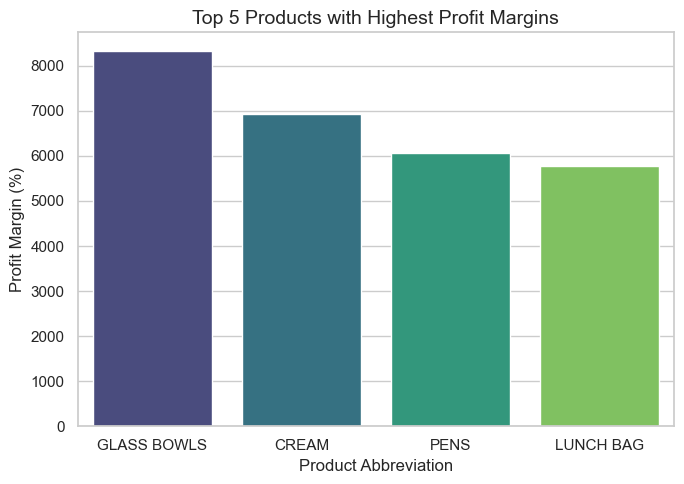

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary mapping full product names to abbreviations
product_abbreviations = {
    'TEA TIME TEA TOWELS': 'TEA TOWELS',
    'SET/5 RED SPOTTY LID GLASS BOWLS': 'GLASS BOWLS',
    'MISELTOE HEART WREATH CREAM': 'CREAM',
    'MINI HIGHLIGHTER PENS': 'PENS',
    'LUNCH BAG RED SPOTTY': 'LUNCH BAG'
}

# Map the abbreviations to the 'Product' column
top_5_df['ProductAbbrev'] = top_5_df['Product'].map(product_abbreviations)

# Plotting the bar chart
plt.figure(figsize=(7, 5))
sns.barplot(x=top_5_df['ProductAbbrev'], y=top_5_df['ProfitMargin'], palette='viridis')
plt.title('Top 5 Products with Highest Profit Margins', fontsize=14)
plt.xlabel('Product Abbreviation')
plt.ylabel('Profit Margin (%)')
plt.tight_layout()

# Displaying the plot
plt.show()

### Question 10 - Customer Satisfaction

#### a) Is there any data available on customer feedback or ratings for products or services?

No, there is no data available on customer feedback or ratings.

#### b) Can you analyze the sentiment or feedback trends, if available?

In case the sentiment data was available, we would do the analysis in the following way.

In [91]:
# !pip install pandas textblob

In [92]:
from textblob import TextBlob 

In [93]:
df.loc[:,'Sentiment'] = df['Customer Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize sentiment 
df.loc[:,'SentimentCategory'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Display the result
df[['Customer Feedback', 'Sentiment', 'SentimentCategory']]

,Customer Feedback,Sentiment,SentimentCategory
0,Fast shipping.,0.20,Positive
1,Excellent customer service.,1.00,Positive
2,Poor quality.,-0.40,Negative
3,Excellent customer service.,1.00,Positive
4,Excellent customer service.,1.00,Positive
...,...,...,...
541904,Not worth the price.,-0.15,Negative
541905,Not worth the price.,-0.15,Negative
541906,Fast shipping.,0.20,Positive
541907,Highly recommended!,0.20,Positive


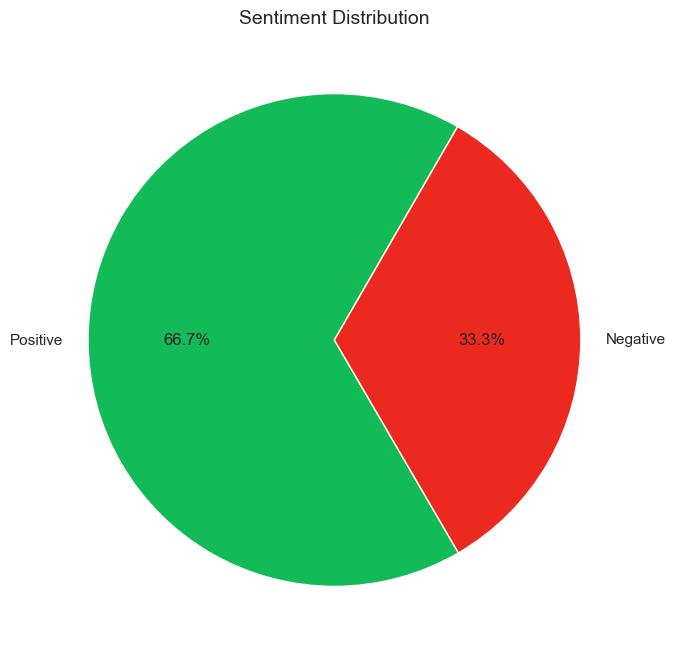

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment category
sentiment_counts = df['SentimentCategory'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=60, colors=['#12bb58', '#ec291f'])
plt.title('Sentiment Distribution',fontsize=14)
plt.show()